In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os, cv2
from tqdm.auto import tqdm

In [ ]:
!mkdir -p /root/.kaggle
!mv /content/kaggle.json /root/.kaggle

In [ ]:
import kaggle

In [ ]:
!kaggle competitions download -c dog-breed-identification

 99% 684M/691M [00:07<00:00, 131MB/s]
100% 691M/691M [00:07<00:00, 94.7MB/s]


In [ ]:
!unzip -q /content/dog-breed-identification.zip

In [ ]:
!rm -rf /content/sample_submission.csv /content/dog-breed-identification.zip

In [ ]:
df = pd.read_csv('/content/labels.csv')

In [ ]:
df['id'] = df['id']+'.jpg'

In [ ]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [ ]:
batch_size = 64

In [ ]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30,
                                                       horizontal_flip=True,
                                                       validation_split=0.1)

In [ ]:
train = idg.flow_from_dataframe(df,
                                '/content/train',
                                'id',
                                'breed',
                                target_size = (380,380),
                                batch_size = batch_size,
                                shuffle = False,
                                subset = 'training')

Found 9200 validated image filenames belonging to 120 classes.


In [ ]:
val = idg.flow_from_dataframe(df,
                              '/content/train',
                              'id',
                              'breed',
                              target_size = (380,380),
                              batch_size = batch_size,
                              shuffle = False,
                              subset = 'validation')

Found 1022 validated image filenames belonging to 120 classes.


In [ ]:
#input layer
input = tf.keras.layers.Input((380,380,3),
                                   name = 'Input')
#preprocessing
##vgg
vgg_prep = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input,
                                  name = 'vgg_prep')(input)
##xception
xception_prep = tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input,
                                       name = 'xception_prep')(input)

#model
##vgg
vgg_notop = tf.keras.applications.vgg16.VGG16(include_top = False,
                                               input_shape = (380,380,3))
vgg_notop.trainable = False
vgg = vgg_notop(vgg_prep)

##xception
xception_notop = tf.keras.applications.xception.Xception(include_top = False,
                                                   input_shape = (380,380,3))
xception_notop.trainable = False
xception = xception_notop(xception_prep)

#GAP layer
##vgg
vgg_gap = tf.keras.layers.GlobalAveragePooling2D(name = 'vgg_gap')(vgg)

##xception
xception_gap = tf.keras.layers.GlobalAveragePooling2D(name = 'xception_gap')(xception)

#concatination layer
concat = tf.keras.layers.Concatenate()([vgg_gap,xception_gap])

#vgg 512
#xception 2048
2560

#categorization_layer
hidden = tf.keras.layers.Dense(256,
                               activation='relu',
                               name = 'hidden')(concat)
output = tf.keras.layers.Dense(120,
                               activation = 'softmax',
                               name = 'output')(hidden)


83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
final_model = tf.keras.models.Model(inputs = [input],outputs = [output])

In [ ]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 380, 380, 3)]        0         []                            
                                                                                                  
 vgg_prep (Lambda)           (None, 380, 380, 3)          0         ['Input[0][0]']               
                                                                                                  
 xception_prep (Lambda)      (None, 380, 380, 3)          0         ['Input[0][0]']               
                                                                                                  
 vgg16 (Functional)          (None, 11, 11, 512)          1471468   ['vgg_prep[0][0]']            
                                                          8                                   

In [ ]:
final_model.compile(tf.keras.optimizers.SGD(),
                    tf.keras.losses.categorical_crossentropy,
                    metrics = ['accuracy'])

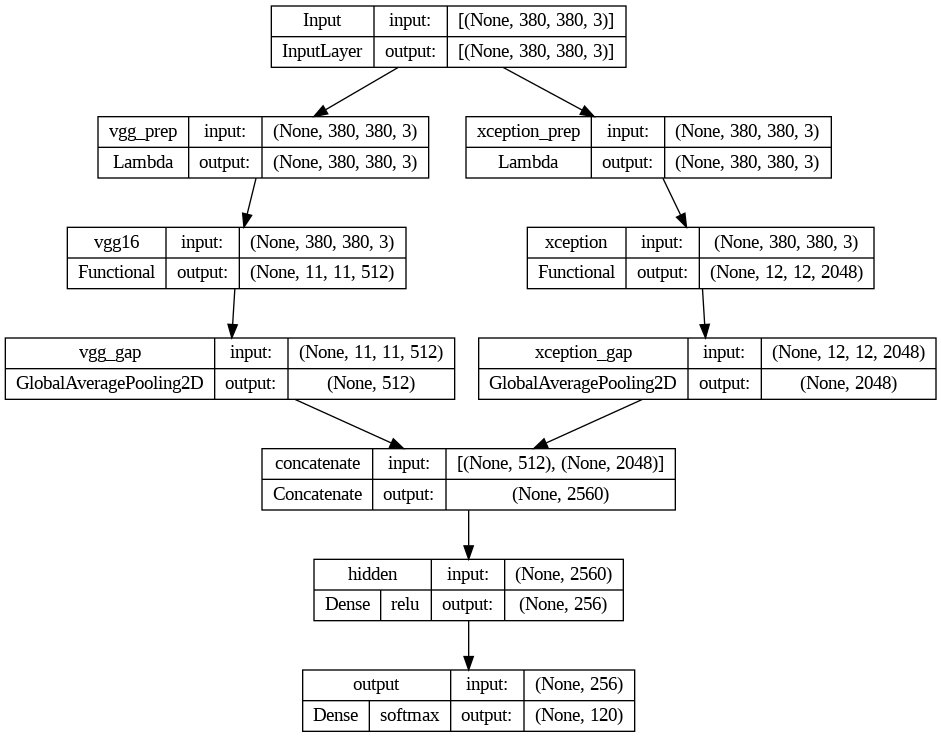

In [ ]:
tf.keras.utils.plot_model(final_model,
                          show_shapes = True,
                          show_layer_activations = True)

In [ ]:
final_model.fit(train,
                batch_size = batch_size,
                epochs = 10,
                validation_data = val)

Epoch 1/10
144/144 [==============================] - 531s 3s/step - loss: 3.3808 - accuracy: 0.2476 - val_loss: 2.2064 - val_accuracy: 0.4335
Epoch 2/10
144/144 [==============================] - 456s 3s/step - loss: 1.6902 - accuracy: 0.5551 - val_loss: 1.5084 - val_accuracy: 0.5959
Epoch 3/10
144/144 [==============================] - 491s 3s/step - loss: 1.2089 - accuracy: 0.6726 - val_loss: 1.3249 - val_accuracy: 0.6223
Epoch 4/10
144/144 [==============================] - 455s 3s/step - loss: 1.0036 - accuracy: 0.7207 - val_loss: 1.1623 - val_accuracy: 0.6703
Epoch 5/10
144/144 [==============================] - 458s 3s/step - loss: 0.8619 - accuracy: 0.7555 - val_loss: 1.0754 - val_accuracy: 0.6771
Epoch 6/10
144/144 [==============================] - 492s 3s/step - loss: 0.7637 - accuracy: 0.7851 - val_loss: 1.0392 - val_accuracy: 0.6937
Epoch 7/10
144/144 [==============================] - 493s 3s/step - loss: 0.6950 - accuracy: 0.7979 - val_loss: 1.0223 - val_accuracy: 0.7025

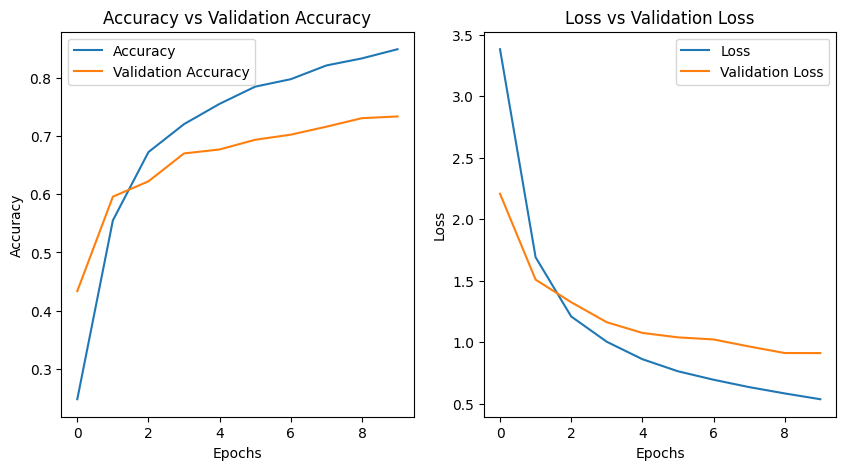

In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(final_model.history.history['accuracy'],label = 'Accuracy')
plt.plot(final_model.history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(final_model.history.history['loss'],label = 'Loss')
plt.plot(final_model.history.history['val_loss'],label = 'Validation Loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()